In [4]:
# General imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Pre-processing related imports
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk import ngrams
from collections import Counter
import nltk.collocations
import re
import gensim
from gensim.utils import simple_preprocess

# Modelling Imports
import sklearn
import sklearn.metrics
import sklearn.naive_bayes
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Useful relative paths
data_directory = './data/NELA'
model_directory ='./models'

# 1. – Exploration of dataset

In [149]:
df_true = pd.read_csv('{}/true.csv'.format(data_directory))
df_false = pd.read_csv('{}/false.csv'.format(data_directory))

In [150]:
X = df_true.append(df_false,ignore_index=True)
from sklearn.utils import shuffle
X = shuffle(X,random_state=0)

## 1.1 See a few instance and column *names*

In [151]:
X.head(5)

,Unnamed: 0,author,collection_utc,content,date,id,published,published_utc,source,title,url,label
17847,17847,NaN,1567550262,A Dublin Castle security man who lost control ...,2019-01-30,theirishtimes--2019-01-30--Dublin Castle secur...,2019-01-30 21:16:44+00:00,1548901004,theirishtimes,Dublin Castle security man guilty of work plac...,https://www.irishtimes.com/news/crime-and-law/...,1
5591,5591,"Chris Strohm, Shannon Pettypiece, Bloomberg",1567540886,President Donald Trump has asserted executive ...,2019-05-08,fortune--2019-05-08--Trump Asserts Executive P...,2019-05-08 14:45:04+00:00,1557341104,fortune,Trump Asserts Executive Privilege Over All Mue...,http://fortune.com/2019/05/08/trump-executive-...,1
11614,11614,NaN,1567549621,This is adapted from Beast special corresponde...,2019-02-04,thedailybeast--2019-02-04--Were in the Age of ...,2019-02-04 10:14:51+00:00,1549293291,thedailybeast,We’re in the Age of Fracture. Here’s How We St...,http://feedproxy.google.com/~r/thedailybeast/a...,1
34699,12385,admin,1567536198,Mayor Pete Buttigieg warned Saturday of the ri...,2019-07-22,prisonplanet--2019-07-22--Pete Buttigieg White...,2019-07-22 12:15:51+00:00,1563812151,prisonplanet,Pete Buttigieg: White Supremacy Threatens to E...,https://www.prisonplanet.com/pete-buttigieg-wh...,0
10455,10455,Josh Kovensky,1575937045,Justice Department Inspector General Michael H...,2019-12-09,talkingpointsmemo--2019-12-09--The Top Five ‘D...,"Mon, 09 Dec 2019 23:01:17 +0000",1575950477,talkingpointsmemo,The Top Five ‘Deep State’ Conspiracy Theories ...,https://talkingpointsmemo.com/muckraker/the-to...,1


In [152]:
X.columns

Index(['Unnamed: 0', 'author', 'collection_utc', 'content', 'date', 'id',
       'published', 'published_utc', 'source', 'title', 'url', 'label'],
      dtype='object')

In [153]:
X=X.drop(labels=['Unnamed: 0', 'author','collection_utc','id','published','published_utc','url' ],axis=1)
df_true=df_true.drop(labels=['Unnamed: 0', 'author','collection_utc','id','published','published_utc','url' ],axis=1)
df_false=df_false.drop(labels=['Unnamed: 0', 'author','collection_utc','id','published','published_utc','url' ],axis=1)

## 1.2 Distribution of labels

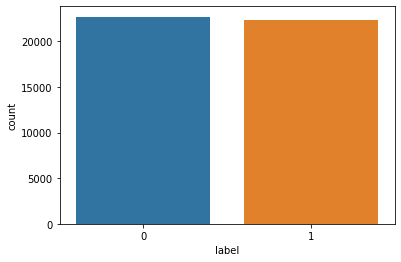

In [154]:
sns.countplot(x=X['label'])

Quite balanced!

## 1.3 Null values

In [155]:
X.isnull().sum()

content    0
date       0
source     0
title      1
label      0
dtype: int64

## 1.4 See example of first news it classifies as "Fake" 

In [156]:
print('title 1: '+X[X.label==0]['title'].iloc[0])
print('content 1: '+X[X.label==0]['content'].iloc[0])

title 1: Pete Buttigieg: White Supremacy Threatens to End United States
content 1: Mayor Pete Buttigieg warned Saturday of the rising threat of white supremacy, noting that it could end the United States of America.

“It could be the lurking issue that ends this country in the future if we don’t wrangle it down in our time,” he told ABC News.

Buttigieg argued that white supremacy started the Civil War and almost ended the United States.

“That is the only issue that almost ended this country,” he said.

The South Bend Mayor frequently criticizes the United States for failing to provide racial equality, warning of a new Civil War.

This article was posted: Monday, July 22, 2019 at 7:15 am


### We make the following remarks:

*   Fake articles are "genuine" fake news, in the sense that they are raw and not specifially pointed out as fake news (as is the case in Politifact.com datasets)
*   Articles seem quite long and and representative of actual content. 



## 1.5 Save this CSV as our unprocessed basis

In [157]:
X.to_csv('{}/complete_unprocessed.csv'.format(data_directory),index=False)

# 2. – Data Pre-processing

## 2.1 Check remaing NA values

In [158]:
X.isnull().sum()

content    0
date       0
source     0
title      1
label      0
dtype: int64

In [159]:
X=X.dropna()
df_true=df_true.dropna()
df_false=df_false.dropna()

## 2.2 New feature combining title and content

In [160]:
X['full_content'] = X['title']+" "+X['content']
df_true['full_content'] = df_true['title']+df_true['content']
df_false['full_content'] = df_false['title']+df_false['content']

## 2.3 Define & apply preprocessing function to this new feature

In [161]:
nltk.download("stopwords")
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
nltk.download("punkt")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/axelbogos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/axelbogos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/axelbogos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [162]:
def preprocess(text):
    text=re.sub('[^A-Za-z]',' ', text )
    text=re.sub('\n\n',' ', text )
    text=text.lower()
    tokenized_text = nltk.word_tokenize(text)
    tokenized_text = [word for word in tokenized_text if not word in stop_words and len(word)>1]
    tokenized_text =[lemmatizer.lemmatize(word) for word in tokenized_text] 
    result = ' '.join(tokenized_text)
    return result

In [164]:
X['full_preprocessed']=X['full_content'].apply(preprocess)
#df_true['full_preprocessed']=df_true['full_content'].apply(preprocess)
#df_false['full_preprocessed']=df_false['full_content'].apply(preprocess)

## 2.4 Get Most Common Bigrams before and after pre-processing (long to run, careful)

In [61]:
# True articles. Comment out if only want overall dataset bigrams

#true_content_bigrams=df_true['full_content'].apply(lambda x: x.split())
#true_processed_bigrams=df_true['full_preprocessed'].apply(lambda x: x.split())

# False articles. Comment out if only want overall dataset bigrams

#false_content_bigrams=df_false['full_content'].apply(lambda x: x.split())
#false_processed_bigrams=df_false['full_preprocessed'].apply(lambda x: x.split())

full_content_bigrams=X['full_content'].apply(lambda x: x.split())
full_processed_bigrams=X['full_preprocessed'].apply(lambda x: x.split())

### 2.4.1 Before Pre-processing

#### 2.4.1.1 True Articles Before Pre-processing

In [62]:
finder = BigramCollocationFinder.from_documents(true_content_bigrams.values)
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder.apply_freq_filter(1)
ngram_list = [pair for row in true_content_bigrams for pair in ngrams(row, 2)]
counts = Counter(ngram_list).most_common(15)
pd.DataFrame.from_records(counts, columns=['gram', 'count'])

,gram,count
0,"(of, the)",68437
1,"(in, the)",56891
2,"(to, the)",31368
3,"(on, the)",24360
4,"(for, the)",20416
5,"(at, the)",17673
6,"(to, be)",17666
7,"(and, the)",16981
8,"(in, a)",16529
9,"(with, the)",14724


#### 2.4.1.2 False Articles Before Pre-processing

In [63]:
finder = BigramCollocationFinder.from_documents(false_content_bigrams.values)
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder.apply_freq_filter(1)
ngram_list = [pair for row in true_content_bigrams for pair in ngrams(row, 2)]
counts = Counter(ngram_list).most_common(15)
pd.DataFrame.from_records(counts, columns=['gram', 'count'])

,gram,count
0,"(of, the)",68437
1,"(in, the)",56891
2,"(to, the)",31368
3,"(on, the)",24360
4,"(for, the)",20416
5,"(at, the)",17673
6,"(to, be)",17666
7,"(and, the)",16981
8,"(in, a)",16529
9,"(with, the)",14724


#### 2.4.1.3 Full dataset Before Pre-processing

In [44]:
finder = BigramCollocationFinder.from_documents(full_content_bigrams.values)
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder.apply_freq_filter(1)
ngram_list = [pair for row in full_content_bigrams for pair in ngrams(row, 2)]
counts = Counter(ngram_list).most_common(15)
pd.DataFrame.from_records(counts, columns=['gram', 'count'])

,gram,count
0,"(of, the)",143818
1,"(in, the)",110533
2,"(to, the)",66235
3,"(on, the)",46505
4,"(for, the)",38645
5,"(and, the)",36492
6,"(to, be)",34443
7,"(that, the)",33354
8,"(at, the)",32506
9,"(in, a)",29826


### 2.4.2 After Pre-processing

#### 2.4.2.1 True Articles After Pre-processing

In [64]:
finder = BigramCollocationFinder.from_documents(true_processed_bigrams.values)
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder.apply_freq_filter(1)
ngram_list = [pair for row in true_processed_bigrams for pair in ngrams(row, 2)]
counts = Counter(ngram_list).most_common(15)
pd.DataFrame.from_records(counts, columns=['gram', 'count'])

,gram,count
0,"(donald, trump)",3860
1,"(white, house)",3806
2,"(united, state)",3610
3,"(new, york)",3354
4,"(last, year)",3236
5,"(prime, minister)",2968
6,"(president, donald)",2177
7,"(per, cent)",2030
8,"(last, week)",1882
9,"(president, trump)",1677


#### 2.4.2.2 False Articles After Pre-processing

In [65]:
finder = BigramCollocationFinder.from_documents(false_processed_bigrams.values)
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder.apply_freq_filter(1)
ngram_list = [pair for row in false_processed_bigrams for pair in ngrams(row, 2)]
counts = Counter(ngram_list).most_common(15)
pd.DataFrame.from_records(counts, columns=['gram', 'count'])

,gram,count
0,"(united, state)",6368
1,"(donald, trump)",5687
2,"(new, york)",5141
3,"(president, trump)",5098
4,"(white, house)",4251
5,"(social, medium)",2521
6,"(president, donald)",2520
7,"(last, year)",1941
8,"(trump, administration)",1928
9,"(prime, minister)",1793


#### 2.4.2.3 Full dataset After Pre-processing

In [46]:
finder = BigramCollocationFinder.from_documents(full_processed_bigrams.values)
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder.apply_freq_filter(1)
ngram_list = [pair for row in full_processed_bigrams for pair in ngrams(row, 2)]
counts = Counter(ngram_list).most_common(15)
pd.DataFrame.from_records(counts, columns=['gram', 'count'])

,gram,count
0,"(united, state)",9969
1,"(donald, trump)",9539
2,"(new, york)",8487
3,"(white, house)",8053
4,"(president, trump)",6743
5,"(last, year)",4814
6,"(prime, minister)",4755
7,"(president, donald)",4681
8,"(social, medium)",4150
9,"(trump, administration)",3585


## 2.5 Verify Distribution of length of entries, and remove outliers

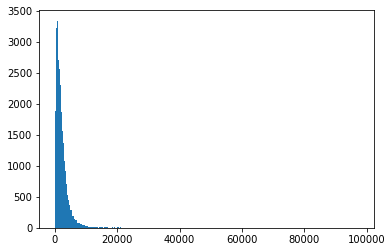

In [90]:
plt.hist([len(x) for x in X['full_preprocessed']], bins=500)
plt.show()

In [91]:
print('Percent of entries with atleast 10,000 words: {}%'.format(round(len([x for x in X['full_preprocessed'] if len(x) >=10000])*100/X.shape[0],3)))
print('Percent of entries with atleast 8000 words: {}%'.format(round(len([x for x in X['full_preprocessed'] if len(x) >=8000])*100/X.shape[0],3)))

Percent of entries with atleast 10,000 words: 1.373%
Percent of entries with atleast 8000 words: 2.485%


Lets get rid of the distribution tail 

In [ ]:
X=X[X['full_preprocessed'].apply(lambda x: len(x) < 8000)]

## 2.6 Save processed dataframe as csv

In [ ]:
X.to_csv('{}/complete_processed.csv'.format(data_directory), index=False)

## 2.7 – Store Current X and y values for reccurent use

In [94]:
y = X['label']
X.drop('label',axis=1)
;

,content,date,source,title,full_content,full_preprocessed
17847,A Dublin Castle security man who lost control ...,2019-01-30,theirishtimes,Dublin Castle security man guilty of work plac...,Dublin Castle security man guilty of work plac...,dublin castle security man guilty work place a...
5591,President Donald Trump has asserted executive ...,2019-05-08,fortune,Trump Asserts Executive Privilege Over All Mue...,Trump Asserts Executive Privilege Over All Mue...,trump asserts executive privilege mueller docu...
34699,Mayor Pete Buttigieg warned Saturday of the ri...,2019-07-22,prisonplanet,Pete Buttigieg: White Supremacy Threatens to E...,Pete Buttigieg: White Supremacy Threatens to E...,pete buttigieg white supremacy threatens end u...
10455,Justice Department Inspector General Michael H...,2019-12-09,talkingpointsmemo,The Top Five ‘Deep State’ Conspiracy Theories ...,The Top Five ‘Deep State’ Conspiracy Theories ...,top five deep state conspiracy theory debunked...
14989,Theresa May is set to force her cabinet to kee...,2019-01-22,thehuffingtonpostuk,Theresa May Set To Force Ministers To Keep No-...,Theresa May Set To Force Ministers To Keep No-...,theresa may set force minister keep no-deal br...
...,...,...,...,...,...,...
30403,A 2018 Pregnancy Center Study from the Charlot...,2019-08-01,liveaction,Report: Most pregnancy centers get no public f...,Report: Most pregnancy centers get no public f...,report pregnancy center get public funding sav...
21243,Alabama Gov. Kay Ivey on Thursday issued an ap...,2019-08-29,usatoday,Alabama Gov. Kay Ivey apologizes for appearing...,Alabama Gov. Kay Ivey apologizes for appearing...,alabama gov kay ivey apologizes appearing raci...
42613,"“Sooo……I’m recused, but when people accuse us ...",2019-04-17,truepundit,Kim Foxx Called Jussie Smollett ‘Washed Up Cel...,Kim Foxx Called Jussie Smollett ‘Washed Up Cel...,kim foxx called jussie smollett washed celeb l...
43567,Ohio Republican Rep. Jim Jordan said anything ...,2019-03-24,truepundit,Jim Jordan Wants Anything Related To Mueller P...,Jim Jordan Wants Anything Related To Mueller P...,jim jordan want anything related mueller probe...


### 3 – Naive-Bayes Bag of Word Baseline

Retrieve X and y if runtime is disconnected

In [5]:
X = pd.read_csv('{}/complete_processed.csv'.format(data_directory))
y = X['label']
X.drop('label',axis=1)
;

''

In [6]:
cv = CountVectorizer()
#norm = sklearn.preprocessing.Normalizer()
X_vectorized = cv.fit_transform(X['full_preprocessed'].values)
#X_vectorized=norm.fit_transform(X_vectorized)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=0)

In [8]:
%%time
gnb_classifier = sklearn.naive_bayes.MultinomialNB()
X_train_test = X_train
y_train_test = y_train
gnb_classifier.fit(X_train_test,y_train_test )
y_pred = gnb_classifier.predict(X_test)
print('Baseline: '+classification_report(y_test, y_pred))

Baseline:               precision    recall  f1-score   support

           0       0.75      0.88      0.81      4422
           1       0.85      0.71      0.77      4374

    accuracy                           0.79      8796
   macro avg       0.80      0.79      0.79      8796
weighted avg       0.80      0.79      0.79      8796

CPU times: user 95.9 ms, sys: 12.1 ms, total: 108 ms
Wall time: 168 ms


### Not bad! And extremely fast

In [172]:
filename = '{}/TFID/baseline_gnb.pkl'.format(model_directory)
pickle.dump(gnb_classifier, open(filename, 'wb'))

## Lets see important features (function adapted from sklearn documentation)

In [15]:
def important_features(vectorizer,classifier,n=20):
    class_labels = classifier.classes_
    feature_names =vectorizer.get_feature_names()

    topn_class1 = sorted(zip(classifier.feature_count_[0], feature_names),reverse=True)[:n]
    topn_class2 = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[:n]

    print("Important words in Fake news")

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print("-----------------------------------------")
    print("Important words in True news")

    for coef, feat in topn_class2:
        print(class_labels[1], coef, feat)

In [16]:
important_features(cv,gnb_classifier,10)

Important words in Fake news
0 36765.0 trump
0 27921.0 said
0 23840.0 president
0 19025.0 one
0 18497.0 would
0 18154.0 people
0 18153.0 year
0 17667.0 state
0 16229.0 time
0 16023.0 new
-----------------------------------------
Important words in True news
1 46499.0 said
1 25059.0 year
1 24200.0 trump
1 20552.0 one
1 19810.0 would
1 17341.0 people
1 17074.0 time
1 16337.0 also
1 16124.0 new
1 15160.0 president
